## Импорт библиотек

Установка библиотеки для чтения epub файлов

In [2]:
!pip install ebooklib

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

random_seed = 42

## Загрузка и чтение текстов

Скачиваем тексты для обучения с репозитория github

In [4]:
if not os.path.isdir('writers'):
  !wget https://github.com/Tortole/authorship_identification/raw/main/writers.zip
  !unzip writers.zip

Методы для чтения и обработки формата epub

In [5]:
# Извлекает содержание epub файла в виде html
def epub_to_html(epub_path):
  book = epub.read_epub(epub_path)
  htmls = []
  for item in book.get_items():
    if item.get_type() == ebooklib.ITEM_DOCUMENT:
      htmls.append(item.get_content())
  return htmls

# Извлекает текст из html
blacklist = ['[document]', 'noscript', 'header', 'html', 'meta', 'head','input', 'script']
def html_to_text(html_text):
  result_text = ''
  soup = BeautifulSoup(html_text, 'html.parser')
  text = soup.find_all(text=True)
  for t in text:
    if t.parent.name not in blacklist:
      result_text += '{} '.format(t)
  return result_text


# Извлекает из epub файла текст
def epub_to_text(epub_path):
  html = epub_to_html(epub_path)
  text = [html_to_text(h) for h in html]
  return text

Чтение и обработка epub файлов

In [6]:
main_folder = 'writers'
authors_texts = {}

for folder in os.listdir(main_folder):
  folder_path = os.path.join(main_folder, folder)
  texts = []
  for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    text = epub_to_text(file_path)
    texts.append(' '.join(text))
  authors_texts[folder] = texts

Удаляем фамилии авторов из текстов

In [8]:
author_names_reg = {
    'pushkin': r'Пушкин\w{0,2}',
    'gogol': r'Гогол\w{0,2}',
    'dostoevsky': r'Достоевск\w{1,3}',
    'tolstoy': r'Толст\w{1,3}',
    'turgenev': r'Тургенев\w{0,2}',
}

for author in authors_texts:
  authors_texts[author] = [re.sub(author_names_reg[author], ' ', text) for text in authors_texts[author]]

Разбиваем тексты на обучающую и тестовую выборки

In [9]:
train_texts = []
test_texts = []
authors = []

for author in authors_texts:
  authors.append(author)
  train, test = train_test_split(authors_texts[author], random_state=random_seed)
  train_texts.append(train)
  test_texts.append(test)

## Обработка текстов

Методы для очистки текста.

Пропускаем текст через токенайзер nltk, избавляясь от любых символов, кроме букв и чисел, дополнительно убираем стоп-слова, объединяем разделённые слова снова в цельные тексты.

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))


# Очистка текста от знаков препинания, спецсимволов и (опционально) стоп-слов c помощью библиотеки nltk
def nltk_cleaner(text, remove_stop_words=True):
  tokenizer_nltk = RegexpTokenizer(r'[0-9а-яА-Яa-zA-Z]+')
  clear_words = tokenizer_nltk.tokenize(text)
  if remove_stop_words:
    clear_words = [w for w in clear_words if w.lower() not in stop_words]
  return ' '.join(clear_words)


def clean_texts(texts):
  clean_texts = []
  for author_texts in train_texts:
    cleans = [nltk_cleaner(t) for t in author_texts]
    clean_texts.append(cleans)
  return clean_texts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Токенезация с помощью keras

In [11]:
train_texts_clean = clean_texts(train_texts)

# Максимальное количество слов, которые учитывает токенайзер
max_words_counts = 30000

tokenizer_keras = Tokenizer(num_words=max_words_counts)
for t in train_texts_clean:
  tokenizer_keras.fit_on_texts(t)

Отбрасываем слова, встречающиеся менее count_border количества раз.

Редко используемые слова могут встречаться только у одного автора и сопоставляться только с ним, поэтому если при распознании они встретятся в тексте у другого автора, то программа может выдать второго за первого.

In [12]:
count_border = 2
low_count_words = [w for w, c in tokenizer_keras.word_counts.items() if c < count_border]
for w in low_count_words:
  del tokenizer_keras.word_index[w]
  del tokenizer_keras.word_counts[w]
  del tokenizer_keras.word_docs[w]

Переводим тексты в спискок индексов.

In [13]:
train_sequences = [tokenizer_keras.texts_to_sequences(t) for t in train_texts]
test_sequences = [tokenizer_keras.texts_to_sequences(t) for t in test_texts]

## Подготовка текстов

Увеличиваем объём выборок.

Делается это так: берём текст, отрезок длины seg_len и сдвиг shift, от начала текста отсчитываем отрезок и выбираем попавшие в него слова (первые seg_len слов), после сдвигаемся на shift слов вперёд, также отсчитываем отрезок и выбираем попавшие в него слова, повторяем процедуру до тех пор, пока отрезок не начнёт выходить за границы текста. Тем самым размер выборок увеличился, а качество обучение не пострадает.

In [14]:
def shift_window(text, seg_len, shift):
  words_len = len(text)
  if words_len <= seg_len:
    return [text + ([0] * (seg_len - words_len))]
  shift_texts = []
  index = 0
  while index + seg_len <= words_len:
    shift_texts.append(text[index:index+seg_len])
    index += shift
  return shift_texts


def create_samples(authors_texts, seg_len, shift):
  сlasses_count = len(authors_texts)
  x_samples = []
  y_samples = []
  for i, texts in enumerate(authors_texts):
    for t in texts:
      shift_lists = shift_window(t, seg_len, shift)
      x_samples += shift_lists
      y_samples += [to_categorical(i, сlasses_count).tolist()] * len(shift_lists)
  return (np.array(x_samples), np.array(y_samples))

In [15]:
seg_len = 1000
shift = 50
x_train, y_train = create_samples(train_sequences, seg_len, shift)
x_test, y_test = create_samples(test_sequences, seg_len, shift)

print('Тексты x_train:')
print(x_train)
print()
print('Метки авторов y_train:')
print(y_train)

Тексты x_train:
[[ 1560   298  3396 ...  1625   264    92]
 [  253   648  3209 ...  2877   218  2221]
 [ 3665   950  3056 ...  4269   956  4491]
 ...
 [   28   488    67 ...  1017 28064  3259]
 [  178  1138  5223 ... 12841  3367 10338]
 [ 3135   251 23723 ...  1249 15343 21123]]

Метки авторов y_train:
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


Создание bag of words (мешок слов) из текстов

In [16]:
x_train_bag_of_words = tokenizer_keras.sequences_to_matrix(x_train.tolist())
x_test_bag_of_words = tokenizer_keras.sequences_to_matrix(x_test.tolist())

## Обучение

Epoch 1/15
633/633 [==============================] - 32s 48ms/step - loss: 0.1082 - accuracy: 0.9805 - val_loss: 0.1235 - val_accuracy: 0.9497
Epoch 2/15
633/633 [==============================] - 24s 38ms/step - loss: 0.0186 - accuracy: 0.9968 - val_loss: 0.1509 - val_accuracy: 0.9407
Epoch 3/15
633/633 [==============================] - 25s 40ms/step - loss: 0.0138 - accuracy: 0.9970 - val_loss: 0.1268 - val_accuracy: 0.9516
Epoch 4/15
633/633 [==============================] - 27s 42ms/step - loss: 0.0105 - accuracy: 0.9975 - val_loss: 0.0868 - val_accuracy: 0.9552
Epoch 5/15
633/633 [==============================] - 25s 39ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0825 - val_accuracy: 0.9631
Epoch 6/15
633/633 [==============================] - 24s 38ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0666 - val_accuracy: 0.9680
Epoch 7/15
633/633 [==============================] - 20s 32ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0507 - val_accuracy:

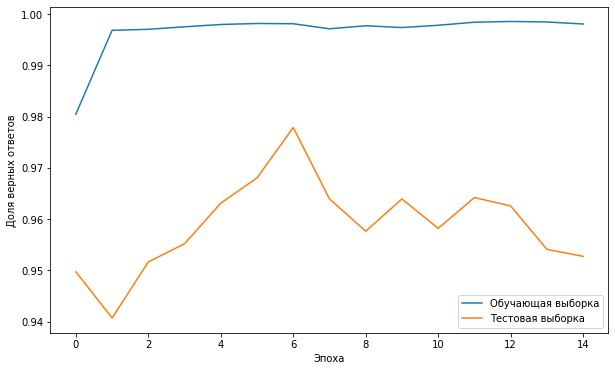

In [17]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(30, input_dim=max_words_counts, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(len(authors), activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train_bag_of_words, 
                    y_train, 
                    epochs=15,
                    validation_data=(x_test_bag_of_words, y_test))

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Тестовая выборка')
plt.xlabel('Эпоха')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Распознование

В качестве примера для распознования возьмём текст из тестовой выборки.

In [19]:
# Для загрузки произвольного текста
# recognition_text = ' '.join(epub_to_text('path_to_epub_file'))

recognition_text = test_texts[0][1]

# Обработка текста
# Токенизация
recognition_text_indexes = tokenizer_keras.texts_to_sequences([recognition_text])[0]
# Для подачи текста на вход сети нужно довести (растянуть или урезать) 
# его длину до одного размера, то есть выполнить pad sequences
# Для этого используем функцию shift_window и составим блоки одного размера
recognition_sample = shift_window(recognition_text_indexes, seg_len, shift)
# Составление мешка слов из текста для распознования
recognition_bag_of_words = tokenizer_keras.sequences_to_matrix(recognition_sample)

# Само распознование
# Модель распознаёт авторство не всего текста целиком, а вероятности авторства
#  блоков на его основе, сделанные с помощью функции shift_window
recognition_predict = model.predict(recognition_bag_of_words)
print('Предсказания сети для каждого блока текста:\n', recognition_predict)

print()

# Чтобы определить номер автора текста, нужно для каждого блока найти наиболее 
# вероятного автора, то есть нужно найти позицию, на которой стоит
# максимальное значение вероятности
recognition_predict = np.argmax(recognition_predict, axis=1)
print('Номера автора для каждого блока текста:\n', recognition_predict)

print()

# Находим вероятности принадлежности текста разным авторам
probability = [0] * len(authors)
for i in range(len(probability)):
  probability[i] = (recognition_predict == i).sum()/len(recognition_predict)
print('Вероятности принадлежности текста разным авторам:\n', probability)

print()

# И в конце выводим информацию о наиболее вероятном авторе текста
recognized_author = np.argmax(probability)
print('Текст написан автором', authors[recognized_author], 'с вероятностью', probability[recognized_author])

Предсказания сети для каждого блока текста:
 [[1.0000000e+00 2.8836727e-04 3.1376749e-02 5.0072438e-01 3.0501306e-02]
 [1.0000000e+00 1.0000169e-03 5.6758940e-02 6.0056239e-01 1.8250048e-02]
 [1.0000000e+00 1.4494061e-03 2.4859905e-02 6.8860948e-01 2.7606398e-02]
 ...
 [9.9991107e-01 8.4583163e-03 9.4672751e-01 4.1812658e-03 2.7844590e-01]
 [9.9997556e-01 1.5550643e-02 8.0540615e-01 2.5417209e-03 3.4390765e-01]
 [9.9998438e-01 4.1134953e-03 6.6211236e-01 3.7589073e-03 4.7904593e-01]]

Номера автора для каждого блока текста:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 